In [1]:
import csv
import matplotlib.pyplot as plt
from shabanipy.labber import LabberData
import numpy as np
import os

from shabanipy.resonators.billys_code.utils.jy_mpl_settings.settings import jy_mpl_rc
from shabanipy.resonators.billys_code.utils.jy_mpl_settings.colors import line_colors

from scipy.optimize import curve_fit
import cmath

import shabanipy.resonators.billys_code.utils.qubit_functions as qf
import shabanipy.resonators.billys_code.utils.resonator_functions as rf
import shabanipy.resonators.billys_code.utils.fluxonium_functions as ff

import matplotlib.patches as patches

plt.style.use(jy_mpl_rc)
root = '/Users/billystrickland/Library/CloudStorage/GoogleDrive-wms269@nyu.edu/.shortcut-targets-by-id/1p4A2foj_vBr4k6wrGEIpURdVkG-qAFgb/nyu-quantum-engineering-lab/labber/data-backups/qubitfridge/Data/'

In [2]:
# The sample identifier is hardcoded here. This might be passed as an argument to make the code more flexible.
sample = '4gmon@v10-05-WMSLJB-CD1'

# Define a function 'plot_and_fit_t1' that processes and fits data, and generates plots.
def plot_and_fit_t1(file_num, figsize=(6, 4)):
    # Define the root path where the data files are located. This is a specific directory on your local machine.
    root = '/Users/billystrickland/Library/CloudStorage/GoogleDrive-wms269@nyu.edu/.shortcut-targets-by-id/1p4A2foj_vBr4k6wrGEIpURdVkG-qAFgb/nyu-quantum-engineering-lab/labber/data-backups/qubitfridge/Data/'
    
    # The sample name and date information are hardcoded into the function. Consider parameterizing these values.
    sample = '4gmon@v10-05-WMSLJB-CD1'
    year = '2024'
    month = '01'
    day = '17'
    
    # Build the file path using the sample and the file number. This will be the location of the .hdf5 data file.
    FILE = f'{root}{year}/{month}/Data_{month}{day}/{sample}-{file_num}.hdf5'

    # Define the channels to read from the data file.
    I_CH, Q_CH, T_CH = ['Digitizer ShabLab - Ch3 - Signal',  # Channel for In-phase signal
                         'Digitizer ShabLab - Ch4 - Signal',  # Channel for Quadrature signal
                         'MQPG - Readout delay']              # Channel for Readout delay time

    # Open the data file using 'LabberData' (likely a custom or external class), and extract the data from the defined channels.
    with LabberData(FILE) as f:
        I = f.get_data(I_CH)  # Get In-phase signal data
        Q = f.get_data(Q_CH)  # Get Quadrature signal data
        time = f.get_data(T_CH)  # Get Readout delay time data

    # Create the first figure for plotting the 2D data (In-phase vs Readout delay over time).
    fig, ax = plt.subplots(figsize=(6.5, 4))
    
    # Plot the In-phase signal as an image. The signal is reversed (`[::-1]`) and scaled by 1e3.
    img = plt.imshow(I[::-1]*1e3, aspect='auto', interpolation='nearest', cmap='viridis', extent=[0, 1, 0, 500])
    
    # Label the axes of the plot.
    plt.xlabel('Readout time (µs)')
    plt.ylabel('Readout delay (ns)')
    
    # Add a color bar to the plot.
    cbar = plt.colorbar(img)
    cbar.set_label('$V_H$ (mV)')  # Set the label for the color bar.

    # Annotate specific points on the plot, such as the start and end of the readout pulse.
    ax.annotate('Readout\n pulse start', 
                xy=(.25, .7), xycoords='figure fraction', color='white')
    ax.annotate('Readout\n pulse end', 
                xy=(.57, .7), xycoords='figure fraction', color='white')

    # Add a label with the subplot index (in this case, 'a' for the first subplot).
    plt.text(-0.2, 1.1, f'({chr(97 + 0)})', transform=plt.gca().transAxes, fontsize=18)
    
    # Adjust the layout to make sure everything fits.
    plt.tight_layout()
    
    # Save the figure as a PDF to the specified path.
#     plt.savefig(f'/Users/billystrickland/Documents/thesis/{sample}_{file_num}_t1_2d.pdf', format='pdf')
    
    # Create the second figure for plotting a simple line graph of the In-phase signal.
    fig, ax = plt.subplots(figsize=(6, 3))
    
    # Plot the first row of the In-phase signal and scale it by 1e3 for mV.
    plt.plot(I[::-1][0]*1e3)
    plt.xlabel('Readout time (µs)')
    plt.ylabel('$V_H$ (mV)')
    
    # Define a rectangle to highlight the integration time period on the plot.
    # The rectangle starts at x=46 (time) and extends for a width of 17.
    rectangle = patches.Rectangle((46, ax.get_ylim()[0]), width=17, height=ax.get_ylim()[1] - ax.get_ylim()[0], 
                                  facecolor='red', alpha=0.2)
    
    # Annotate the rectangle with a label indicating the integration time.
    ax.annotate('Integration time', xy=(.4, .35), xycoords='figure fraction', color='k')
    
    # Add a label with the subplot index (in this case, 'b' for the second subplot).
    plt.text(-0.2, 1., f'({chr(97 + 1)})', transform=plt.gca().transAxes, fontsize=18)
    
    # Add the defined rectangle (highlighting integration time) to the plot.
    ax.add_patch(rectangle)

    # Adjust the layout to make sure everything fits.
    plt.tight_layout()
    
    # Save the figure as a PDF to the specified path.
#     plt.savefig(f'/Users/billystrickland/Documents/thesis/{sample}_{file_num}_t1_readout.pdf', format='pdf')

    # Compute the average of the In-phase signal in the integration time window (46-63 time indices).
    I_avg = np.mean(I[:, 46:63], axis=1)
    
    # Perform a decay fit on the averaged signal and time data. The fitting function is assumed to return 't1' and 'error'.
    t1, err = qf.fit_decay(time * 1e9, I_avg * 1e3, plot_fit=True, voltage=True, figsize=figsize)

    # Return the fitted 't1' value and its error.
    return t1, err


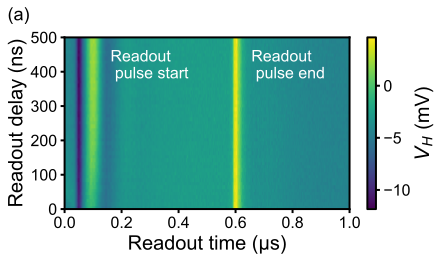

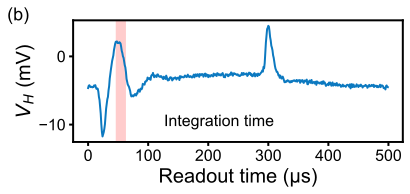

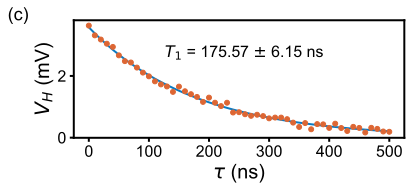

In [3]:
# Define the specific file number to process.
file_num = 108

# Call the 'plot_and_fit_t1' function to plot and fit the data for the given file number.
# It returns the optimized parameters (popt) and the error (err) from the fitting process.
popt, err = plot_and_fit_t1(file_num, figsize=(6, 3))

# Add a label to the plot (likely for identifying the subplot as 'c').
plt.text(-0.2, 1., f'({chr(97 + 2)})', transform=plt.gca().transAxes, fontsize=18)

# Adjust the layout to ensure all elements fit within the plot's boundaries.
plt.tight_layout()

# Optionally save the plot as a PDF. (This line is commented out.)
# plt.savefig(f'/Users/billystrickland/Documents/thesis/{sample}_{file_num}_t1.pdf')
